In [ ]:
import pandas as pd

df = pd.read_csv(path)

df_raw = df.copy()       # full untouched data
df = df_raw.copy()       # new working copy




In [ ]:
import json
import numpy as np

with open('state_centroids.txt') as f:
    state_centroids = json.load(f)

df_raw['state'] = df_raw['state'].str.lower()

df_raw['lat_clean'] = df_raw['state'].map(lambda s: state_centroids.get(s, [np.nan, np.nan])[0])
df_raw['long_clean'] = df_raw['state'].map(lambda s: state_centroids.get(s, [np.nan, np.nan])[1])


In [23]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# ----- 1. Select features (very similar to your clustering code) -----
features_dl = [
    'price', 'odometer', 'year',
    'lat_clean', 'long_clean',
    'manufacturer', 'condition',
    'cylinders', 'fuel', 'title_status', 'drive'
]

df = df_raw.copy()  # same convention you used before

X = df[features_dl].copy()

num_cols = ['price', 'odometer', 'year', 'lat_clean', 'long_clean']
cat_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'drive']

# ----- 2. Preprocessing pipelines -----
numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_dl = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

# This will be a sparse matrix because of OneHotEncoder
X_proc_sparse = preprocess_dl.fit_transform(X)
# Keras wants dense:
X_proc = X_proc_sparse.astype("float32").toarray()

print("X_proc shape:", X_proc.shape)


X_proc shape: (8490, 71)


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

input_dim = X_proc.shape[1]

# ----- Encoder -----
encoder_input = keras.Input(shape=(input_dim,), name="car_features")
x = layers.Dense(128, activation="relu")(encoder_input)
x = layers.Dense(64, activation="relu")(x)
latent = layers.Dense(16, activation="relu", name="latent_embedding")(x)

# ----- Decoder -----
x = layers.Dense(64, activation="relu")(latent)
x = layers.Dense(128, activation="relu")(x)
decoder_output = layers.Dense(input_dim, activation="linear")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="car_autoencoder")

autoencoder.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse")

history = autoencoder.fit(
    X_proc,
    X_proc,
    epochs=30,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

# Separate encoder model to get embeddings
encoder = keras.Model(encoder_input, latent, name="encoder")
embeddings = encoder.predict(X_proc)
print("Embeddings shape:", embeddings.shape)


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1239 - val_loss: 0.0731
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0739 - val_loss: 0.0455
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0428 - val_loss: 0.0304
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0283 - val_loss: 0.0246
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0236 - val_loss: 0.0215
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0206 - val_loss: 0.0185
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - val_loss: 0.0167
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0170 - val_loss: 0.0159
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161 - val_loss: 0.0152
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0155 - val_loss: 0.0147
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - val_loss: 0.0142
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - val_l

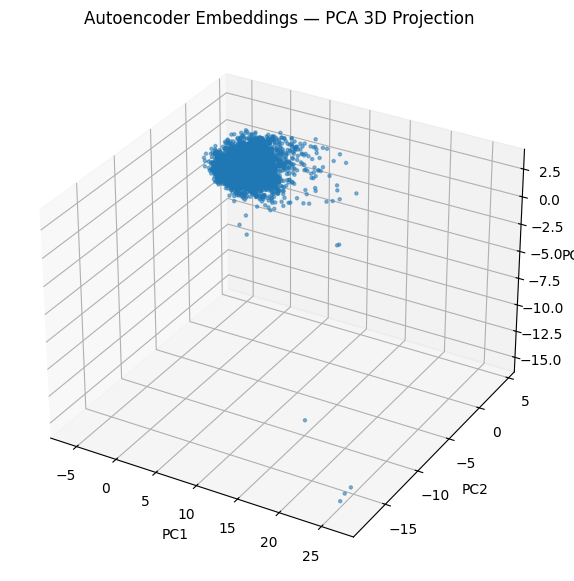

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # just to register 3d proj

pca = PCA(n_components=3)
Z = pca.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], s=5, alpha=0.5)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("Autoencoder Embeddings — PCA 3D Projection")
plt.show()


In [8]:
from numpy.linalg import norm

def recommend_cars_from_features(
    desired_features: dict,
    top_k: int = 5
):
    """
    desired_features: dict with keys from features_dl
    e.g. {
        "price": 25000,
        "odometer": 40000,
        "year": 2018,
        "lat_clean": 38.9,
        "long_clean": -77.0,
        "manufacturer": "toyota",
        "condition": "good",
        "cylinders": "4 cylinders",
        "fuel": "gas",
        "title_status": "clean",
        "drive": "fwd"
    }
    """
    # 1. One-row dataframe
    q_df = pd.DataFrame([desired_features], columns=features_dl)

    # 2. Preprocess
    q_proc_sparse = preprocess_dl.transform(q_df)
    q_proc = q_proc_sparse.astype("float32").toarray()

    # 3. Get embedding
    q_emb = encoder.predict(q_proc)[0]  # shape (latent_dim,)

    # 4. Cosine similarity with all cars
    # embeddings: (N, latent_dim)
    dot = embeddings @ q_emb
    norms = norm(embeddings, axis=1) * norm(q_emb)
    sims = dot / (norms + 1e-8)

    # 5. Top-k indices
    top_idx = np.argsort(-sims)[:top_k]

    return df.iloc[top_idx].assign(similarity=sims[top_idx])


# Example usage:
query = {
    "price": 25000,
    "odometer": 40000,
    "year": 2018,
    "lat_clean": 38.9,
    "long_clean": -77.0,
    "manufacturer": "toyota",
    "condition": "good",
    "cylinders": "4 cylinders",
    "fuel": "gas",
    "title_status": "clean",
    "drive": "fwd"
}

recommended = recommend_cars_from_features(query, top_k=5)
print(recommended[["manufacturer", "price", "odometer", "year", "similarity","lat_clean","long_clean"]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
     manufacturer  price  odometer  year  similarity  lat_clean  long_clean
4404       toyota  17900   26228.0  2018    0.998397  40.590752  -77.209755
4229       toyota  22690   71436.0  2017    0.997502  33.040619  -83.643074
6878       toyota  16997   90068.0  2015    0.996807  33.040619  -83.643074
8340       toyota  12000   46000.0  2014    0.995980  40.590752  -77.209755
7913       toyota  16499   75811.0  2016    0.995840  34.969704  -92.373123


Compare the recommendation between Collabiative filtering and the encoder network

In [26]:
from numpy.linalg import norm

def recommend_cars_feature_space(
    query: dict,
    top_k: int = 5
):
    """
    Nearest-neighbor recommendation in the ORIGINAL processed feature space.
    Uses the same preprocess_dl pipeline as the autoencoder.
    """

    # 1. One-row DataFrame with same columns & order
    q_df = pd.DataFrame([query], columns=features_dl)

    # 2. Preprocess with the same pipeline (DO NOT refit)
    q_proc_sparse = preprocess_dl.transform(q_df)
    q_proc = q_proc_sparse.astype("float32").toarray()  # shape (1, n_features)

    # 3. Compute cosine similarity to all cars in X_proc
    q_vec = q_proc[0]                     # (n_features,)
    dot = X_proc @ q_vec                  # (n_samples,)
    norms = norm(X_proc, axis=1) * norm(q_vec)
    sims = dot / (norms + 1e-8)

    # 4. Top-k indices
    top_idx = np.argsort(-sims)[:top_k]

    # 5. Return the matching rows with similarity
    result = df.iloc[top_idx].copy()
    result["similarity_feature_space"] = sims[top_idx]

    return result


In [28]:
query = {
    "price": 25000,
    "odometer": 40000,
    "year": 2018,
    "lat_clean": 38.9,
    "long_clean": -77.0,
    "manufacturer": "toyota",
    "condition": "good",
    "cylinders": "4 cylinders",
    "fuel": "gas",
    "title_status": "clean",
    "drive": "fwd"
}

cf_recs = recommend_cars_feature_space(query, top_k=5)
print(cf_recs[["manufacturer", "price", "odometer", "year",
               "state", "similarity_feature_space"]])


     manufacturer  price  odometer  year state  similarity_feature_space
4404       toyota  17900   26228.0  2018    pa                  0.979440
8340       toyota  12000   46000.0  2014    pa                  0.931263
4318       toyota  10995  132781.0  2017    nj                  0.928325
4229       toyota  22690   71436.0  2017    ga                  0.916155
6878       toyota  16997   90068.0  2015    ga                  0.888901


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# Make sure it's float64 for numerical stability
X_gmm_input = X_proc.astype(np.float64)

# reduce to 10D for GMM (712 features is too high for GMM it threw and error)
pca_gmm = PCA(n_components=10, random_state=42)
X_gmm = pca_gmm.fit_transform(X_gmm_input)

print("X_gmm shape:", X_gmm.shape)  # (8490, 10)


X_gmm shape: (8490, 10)


In [13]:
from sklearn.mixture import GaussianMixture

def pick_best_gmm(X, k_min=2, k_max=15,
                  covariance="diag", reg_covar=1e-3):
    bics = []
    models = []

    for k in range(k_min, k_max + 1):
        gmm = GaussianMixture(
            n_components=k,
            covariance_type=covariance,
            reg_covar=reg_covar,
            random_state=42,
            n_init=3
        )
        gmm.fit(X)
        bics.append(gmm.bic(X))
        models.append(gmm)

    best_index = np.argmin(bics)
    best_k = best_index + k_min
    best_model = models[best_index]

    print(f"Best number of clusters = {best_k}")
    return best_model, best_k, bics


In [14]:
best_model_auto, best_k_auto, bics_auto = pick_best_gmm(X_gmm)

df_raw["cluster_gmm_auto_input"] = best_model_auto.predict(X_gmm)


Best number of clusters = 15


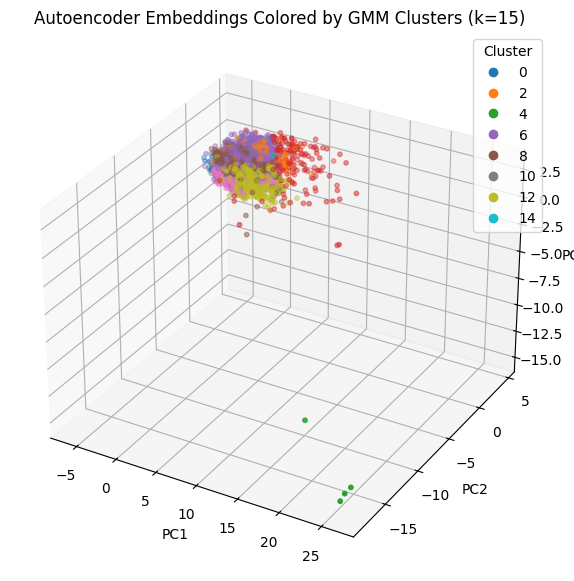

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

labels = df_raw["cluster_gmm_auto_input"].values

pca_emb = PCA(n_components=3, random_state=42)
Z = pca_emb.fit_transform(embeddings)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    Z[:, 0], Z[:, 1], Z[:, 2],
    c=labels,
    cmap="tab10",
    s=10
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title(f"Autoencoder Embeddings Colored by GMM Clusters (k={best_k_auto})")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()
